### Time Series Forecasting with LSTM 

This notebook explores the use of **Long Short-Term Memory (LSTM)** neural networks for time series forecasting.

It focuses on predicting the price of agricultural commodities, using a deep learning model trained on engineered lag-based features. The key steps include:

- Feature engineering: lags, seasonal differences
- Data normalization with MinMaxScaler
- LSTM model definition (one layer + Dropout + Dense)
- Model training and evaluation on training/test splits
- Inverse scaling and performance reporting using RMSE, MAE, and MAPE
- Prediction and visualization for both training and testing periods

The notebook serves as the experimental foundation for building and evaluating deep learning models on time series data.

> **Note**: LSTM models require a consistent feature structure and input shape. Any future predictions must replicate the exact preprocessing steps (feature generation and scaling) used during training. Model performance may vary significantly depending on hyperparameters and window size.


In [12]:
import pandas as pd
import sys
sys.path.insert(0, '../src/')
import importlib
import read_data
importlib.reload(read_data)
from read_data import load_dataset, load_commodity

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [4]:
def create_features(df, target_col, lags=[1], add_month_dummies=True):
    df_feat = pd.DataFrame(index=df.index)
    df_feat[target_col] = df[target_col]
    
    # Lags
    for lag in lags:
        df_feat[f'lag_{lag}'] = df[target_col].shift(lag)
    
    df_feat['lag_12']=df[target_col].shift(12)
    df_feat['diff_seas'] = df[target_col] - df[target_col].shift(12)
    df_feat['diff_price'] = df[target_col] - df[target_col].shift(1)
    
    return df_feat.dropna()

In [41]:
def train_lstm(train, test, target):
    
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    y_train_scaled = scaler_y.fit_transform(train[[target]])
    X_train_scaled = scaler_x.fit_transform(train.drop(columns=[target]))
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))


    X_test_scaled  = scaler_x.transform(test.drop(columns=[target]))
    y_test_scaled = scaler_y.transform(test[[target]])

    X_test_scaled  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    model = Sequential()
    model.add(LSTM(units=50, activation='tanh', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Entrenamiento
    model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

    y_pred_test_scaled = model.predict(X_test_scaled)
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
    y_true_test = scaler_y.inverse_transform(y_test_scaled)

    y_pred_scaled_train = model.predict(X_train_scaled)
    y_pred_train = scaler_y.inverse_transform(y_pred_scaled_train)
    y_true_train = scaler_y.inverse_transform(y_train_scaled) 

    rmse_test = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    mae_test = mean_absolute_error(y_true_test, y_pred_test)
    mape_test = np.mean(np.abs((y_true_test - y_pred_test) / y_true_test)) * 100
    rmse_train = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    mae_train= mean_absolute_error(y_true_train, y_pred_train)
    mape_train = np.mean(np.abs((y_true_train - y_pred_train) / y_true_train)) * 100


    print(f'RMSE_test: {rmse_test:.2f}')
    print(f'MAE_test: {mae_test:.2f}')
    print(f'MAPE_test: {mape_test:.2f}')
    print('------------')
    print(f'RMSE_train: {rmse_train:.2f}')
    print(f'MAE_train: {mae_train:.2f}')
    print(f'MAPE_train: {mape_train:.2f}')
    
    
    return y_pred_test, y_pred_train

### Forecasting Carne

5/5 [==============================] - 0s 3ms/step
RMSE_test: 0.28
MAE_test: 0.26
MAPE_test: 4.71
------------
RMSE_train: 0.13
MAE_train: 0.10
MAPE_train: 2.09


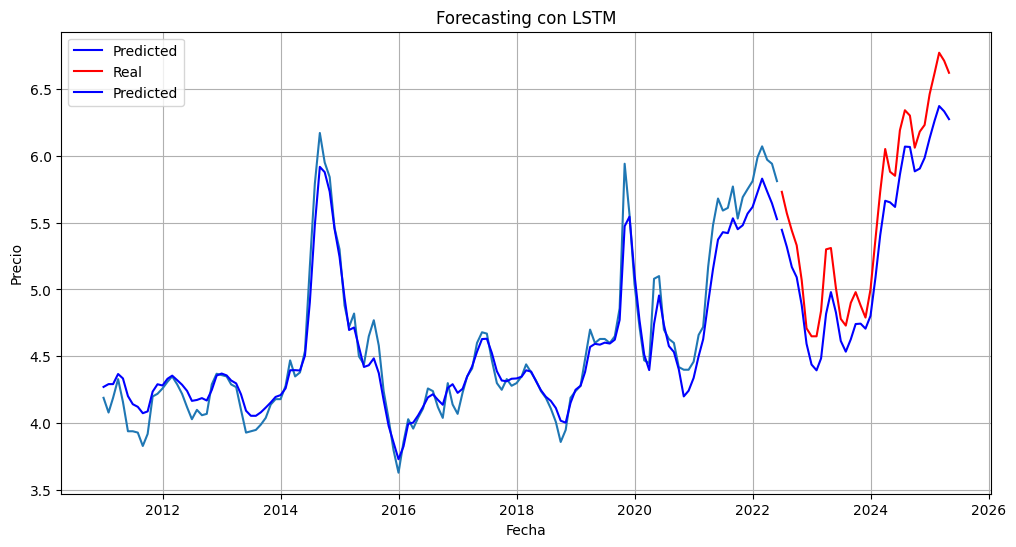

In [36]:
df = load_dataset()
df = create_features(df,'Carne Vacuna')

# Train/Test split temporal
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
y_pred, y_pred_train = train_lstm(train, test, 'Carne Vacuna')

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Carne Vacuna'])
plt.plot(train.index, y_pred_train, label='Predicted', color='blue')
plt.plot(test.index, test['Carne Vacuna'], label='Real', color='red')
plt.plot(test.index, y_pred, label='Predicted', color='blue')
plt.title('Forecasting con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid()
plt.show()

### Forecasting Soja

5/5 [==============================] - 0s 3ms/step
RMSE_test: 13.28
MAE_test: 10.32
MAPE_test: 2.02
------------
RMSE_train: 12.61
MAE_train: 9.78
MAPE_train: 2.06


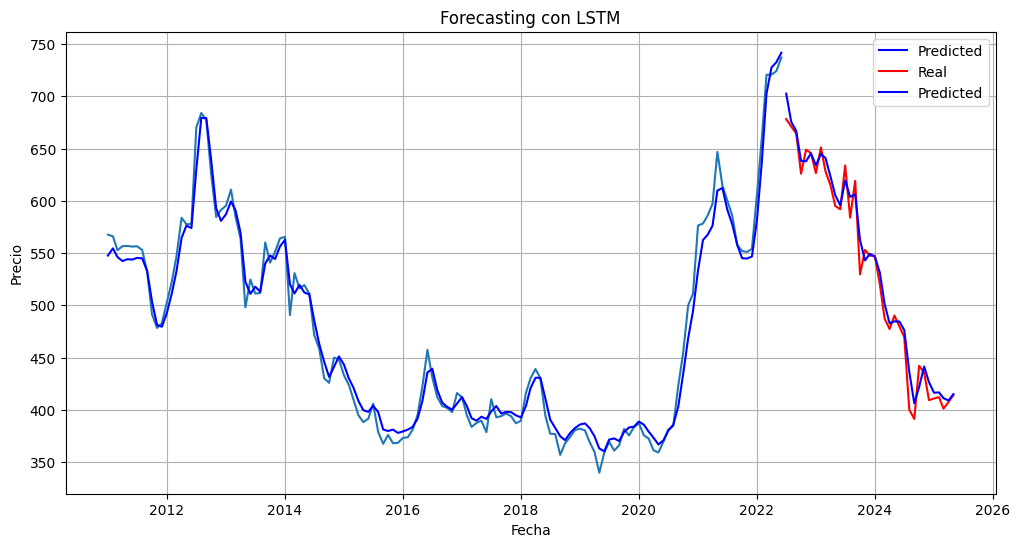

In [38]:
df = load_dataset()
df = create_features(df,'Soja')

# Train/Test split temporal
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

y_pred, y_pred_train = train_lstm(train, test, 'Soja')

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Soja'])
plt.plot(train.index, y_pred_train, label='Predicted', color='blue')
plt.plot(test.index, test['Soja'], label='Real', color='red')
plt.plot(test.index, y_pred, label='Predicted', color='blue')
plt.title('Forecasting con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid()
plt.show()


### Forecasting Trigo

5/5 [==============================] - 0s 2ms/step
RMSE_test: 7.76
MAE_test: 5.29
MAPE_test: 1.62
------------
RMSE_train: 8.10
MAE_train: 6.03
MAPE_train: 2.44


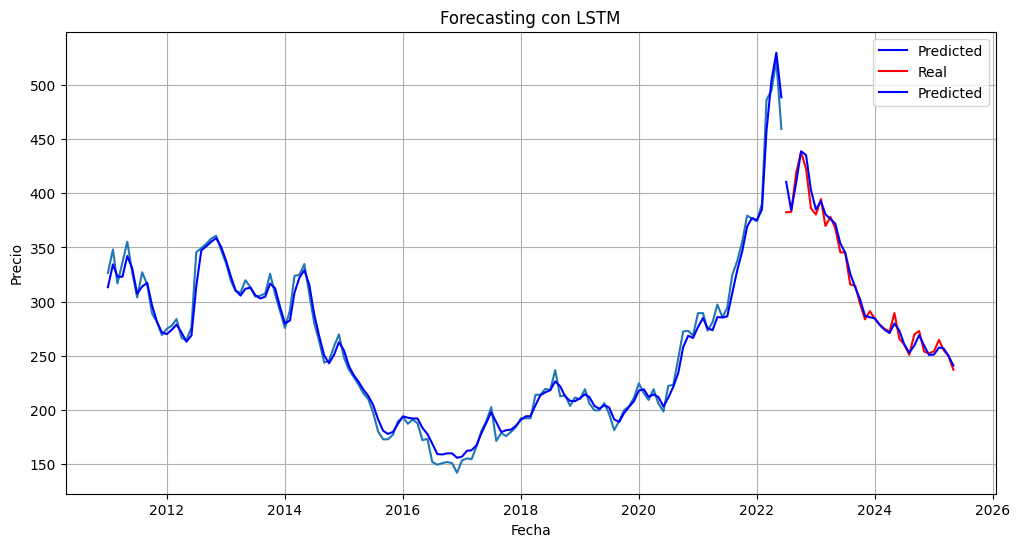

In [42]:
df = load_dataset()
df = create_features(df,'Trigo')

# Train/Test split temporal
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
y_pred, y_pred_train = train_lstm(train, test, 'Trigo')

plt.figure(figsize=(12,6))
plt.plot(train.index, train['Trigo'])
plt.plot(train.index, y_pred_train, label='Predicted', color='blue')
plt.plot(test.index, test['Trigo'], label='Real', color='red')
plt.plot(test.index, y_pred, label='Predicted', color='blue')
plt.title('Forecasting con LSTM')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid()
plt.show()